In [2]:
%matplotlib inline

# define relevant packages; among others: JIRA API
import pandas as pd
import numpy as np
from jira import JIRA 
import matplotlib.pyplot as plt

import seaborn as sns


# ToDos
- [ ] create filters and apply them to a dataframe wo/changing the dataframe itself 

/Example:/
```
price_filter = df.loc[:, 'price'] <= 3000000
df.loc[price_filter, 'price'].hist(bins = 30)
```


 # AERQ Business Owner Reporting Notebook

 ## CMS related reports

In [11]:
# variable definitions in first place

trackSpace = 'https://trackspace.lhsystems.com'
bcUser = 'u293733'
bcPw = '-*27&U9?<8)a'
# search_string = 'project = BCIFCPCMS AND labels in (AERQ) AND Sprint in (openSprints(), futureSprints()) AND issueFunction in aggregateExpression("customfield_10233.sum()") ORDER BY Sprint'


### Procon hours

#### Monthly booked hours in a table

---
** Attention: currently, the below figures come from a test excel sheet only! **
** They do currently not reflect any real spent CMS effort **

---

In [4]:
df_procon = pd.read_excel('./test.xlsx', sheet_name='Procon LTE Data', usecols="A:L")
df_procon.shape

(200, 12)

In [8]:
#from all Procon LEs, filter the CMS entries only
cms_filter = df_procon['LE-Bezeichnung'] == 'AERQ Product'
cms_filter.shape


(200,)

In [9]:
no_staff = len(df_procon.loc[cms_filter, ['Mitarbeiter-Name']].value_counts())
no_hours = df_procon.loc[cms_filter, ['Stunden']].sum()
print(str(no_staff)+' colleagues have booked a total of '+str(no_hours))
df_procon.loc[cms_filter, :].groupby(by=['Export-Datum', 'Mitarbeiter-Name'])[['Stunden']].sum()

5 colleagues have booked a total of Stunden    135.24
dtype: float64


Stunden
Export-Datum Mitarbeiter-Name              
2020-06-26   Kohlert, Christian        5.50
             Pietzner, Mark            8.00
             Thiel, Gregor Michael     2.00
             Weil, Mario              33.50
2020-07-29   Kohlert, Christian        5.00
             Pietzner, Mark            1.00
2020-08-27   Droege, Eberhard          2.00
             Kohlert, Christian        1.00
             Pietzner, Mark           23.90
2020-09-28   Pietzner, Mark           11.00
             Thiel, Gregor Michael     5.50
             Weil, Mario               1.00
2020-10-27   Pietzner, Mark            1.00
             Thiel, Gregor Michael     1.00
2020-11-27   Kohlert, Christian       13.42
             Pietzner, Mark            2.00
             Thiel, Gregor Michael     1.50
2020-12-27   Kohlert, Christian       13.42
             Pietzner, Mark            2.00
             Thiel, Gregor Michael     1.50

- [ ] ToDo: view and replace NaN or Null data 
- [ ] ToDo: review data for its validity and reduce dataset to valid data only (using value_count())

#### Monthly booked hours in a chart

No handles with labels found to put in legend.


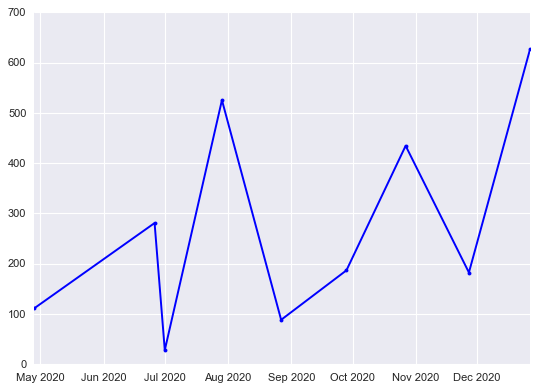

In [124]:
#type(df_procon.groupby(by=['Export-Datum'])[['Stunden']].sum())
#plt.style.available
plt.style.use('seaborn-darkgrid')
plt.legend(loc='center right')
plt.plot(df_procon.groupby(by=['Export-Datum'])[['Stunden']].sum(), c='b', marker = '.', markersize=7)

In [14]:
 ### Velocity per product in current Sprint: AERQ, DISP, BC

In [15]:
# JQL: retrieve all tickets in current Sprint
search_string = 'project = BCIFCPCMS AND Sprint in (openSprints()) ORDER BY sprint'


**JQL Statement**
```
project = BCIFCPCMS AND Sprint in (openSprints()) ORDER BY sprint
```

In [16]:
# create DataFrame with relevant attributes from which further reports are derived
df = pd.DataFrame()
try:
    jiraBc = JIRA(server=trackSpace, basic_auth=(bcUser, bcPw))    # a username/password tuple
    #create lists from found issues to later convert those to a DataFrame
    issue_table = list()
    for issue in jiraBc.search_issues(search_string, maxResults=None):
        labels = 'BC'
        # categorize tickets according to their labels set
        # current categories of interest: BC, AERQ, DISP
        # intended reports: velocity spent on a certain topic
        if issue.fields.labels is not None:
            if 'DISP@LH777' in issue.fields.labels:
                 labels = 'DISP@LH777'
            if 'AERQ' in issue.fields.labels:
                labels = 'AERQ'
        issue_table_row = [issue.key, issue.fields.summary, issue.fields.created, issue.fields.updated, issue.fields.customfield_10233, issue.fields.status.name, labels]
        issue_table.append(issue_table_row)
    issue_table_header = ['Key', 'Summary', 'Created', 'Updated', 'Story Points', 'Status', 'Labels']
    df = pd.DataFrame(issue_table)
    df.columns = issue_table_header
except Exception as e:
    print(e)



#### Velocity table and chart per category

            Story Points      %
Labels                         
AERQ                49.0  51.58
BC                  20.0  21.05
DISP@LH777          26.0  27.37


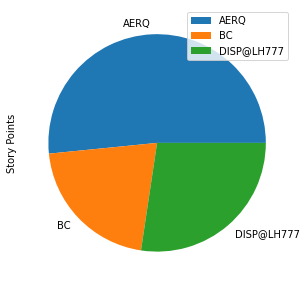

In [17]:
    # group selected tickets (current, future sprints) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


#### Tickets in current Sprint

In [18]:
# Width of the display in characters. If set to None and pandas will correctly auto-detect the width.
pd.set_option('display.width', None)
print (df[['Key', 'Story Points', 'Labels']])

              Key  Story Points      Labels
0  BCIFCPCMS-4313          13.0  DISP@LH777
1  BCIFCPCMS-4271          20.0          BC
2  BCIFCPCMS-4508           8.0        AERQ
3  BCIFCPCMS-4495           5.0        AERQ
4  BCIFCPCMS-4493          13.0        AERQ
5  BCIFCPCMS-4510           8.0  DISP@LH777
6  BCIFCPCMS-4491          20.0        AERQ
7  BCIFCPCMS-4515           5.0  DISP@LH777
8  BCIFCPCMS-4507           3.0        AERQ


 ### Velocity per product in future Sprints: AERQ, DISP, BC

In [19]:
# JQL: get all non-closed tickets from future Sprints (thus: Refined Sprint, existing Sprints > current one)
search_string = 'project = BCIFCPCMS AND Sprint in (futureSprints()) AND status not in (Done, Closed, Resolved) ORDER BY sprint'


**JQL Statement**
```
project = BCIFCPCMS AND Sprint in (futureSprints()) AND status not in (Done, Closed, Resolved) ORDER BY sprint
```

In [20]:
# create DataFrame with relevant attributes from which further reports are derived
df = pd.DataFrame()
try:
    jiraBc = JIRA(server=trackSpace, basic_auth=(bcUser, bcPw))    # a username/password tuple
    #create lists from found issues to later convert those to a DataFrame
    issue_table = list()
    for issue in jiraBc.search_issues(search_string, maxResults=None):
        labels = 'BC'
        # categorize tickets according to their labels set
        # current categories of interest: BC, AERQ, DISP
        # intended reports: velocity spent on a certain topic
        if issue.fields.labels is not None:
            if 'DISP@LH777' in issue.fields.labels:
                 labels = 'DISP@LH777'
            if 'AERQ' in issue.fields.labels:
                labels = 'AERQ'
        issue_table_row = [issue.key, issue.fields.summary, issue.fields.created, issue.fields.updated, issue.fields.customfield_10233, issue.fields.status.name, labels]
        issue_table.append(issue_table_row)
    issue_table_header = ['Key', 'Summary', 'Created', 'Updated', 'Story Points', 'Status', 'Labels']
    df = pd.DataFrame(issue_table)
    df.columns = issue_table_header
except Exception as e:
    print(e)



#### Velocity table and chart per category

            Story Points      %
Labels                         
AERQ                94.0  11.81
BC                 666.0  83.67
DISP@LH777          36.0   4.52


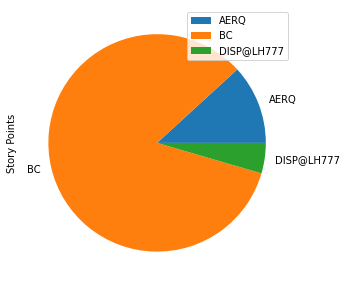

In [21]:
    # group selected tickets (current, future sprints) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


 ### Velocity per product in past month per category: AERQ, DISP, BC

In [30]:
from datetime import date, timedelta

previous_month = date.today().replace(day=1) - timedelta(days=1)
# create DataFrame with relevant attributes from which further reports are derived
search_string = ('project = BCIFCPCMS AND ('
'updatedDate >= " ' + str(previous_month.year) + '/' + str(previous_month.month) + '/' + '01" '
'AND updatedDate <= " ' + str(previous_month.year) + '/' + str(previous_month.month) + '/' + str(previous_month.day) + '") '
'AND status != open ORDER BY  updated DESC')


**JQL Statement**
```
project = "BCIFCPCMS AND updatedDate >= 'yyyy/mm-1/01' AND updatedDate <= 'yyyy/mm-1/last_day_of_month'" 
```

In [31]:
df = pd.DataFrame()
try:
    jiraBc = JIRA(server=trackSpace, basic_auth=(bcUser, bcPw))    # a username/password tuple
    #create lists from found issues to later convert those to a DataFrame
    issue_table = list()
    for issue in jiraBc.search_issues(search_string, maxResults=None):
        labels = 'BC'
        # categorize tickets according to their labels set
        # current categories of interest: BC, AERQ, DISP
        # intended reports: velocity spent on a certain topic
        if issue.fields.labels is not None:
            if 'DISP@LH777' in issue.fields.labels:
                 labels = 'DISP@LH777'
            if 'AERQ' in issue.fields.labels:
                labels = 'AERQ'
        issue_table_row = [issue.key, issue.fields.summary, issue.fields.created, \
                           issue.fields.updated, issue.fields.resolutiondate, \
                           issue.fields.customfield_10233, \
                           issue.fields.status.name, labels]
        issue_table.append(issue_table_row)
    issue_table_header = ['Key', 'Summary', 'Created', \
                          'Updated', 'Resolved', \
                          'Story Points', \
                          'Status', 'Labels']
    df = pd.DataFrame(issue_table)
    df.columns = issue_table_header
except Exception as e:
    print(e)


#### Velocity table and chart per category

1 2021
            Story Points      %
Labels                         
AERQ                49.0  31.61
BC                  93.0  60.00
DISP@LH777          13.0   8.39


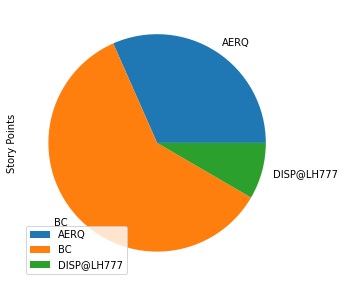

In [32]:
    # group selected tickets (previous month) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    df_new = df.groupby('Labels')[['Story Points']].sum()
    # add a Velocity's percentage value per category
    df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
    print (str(previous_month.month) + ' ' + str(previous_month.year))
    print(df_new)
    plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


 ### Velocity per product in current month per category: AERQ, DISP, BC

In [38]:
current_month = date.today()
search_string = ('project = BCIFCPCMS AND ('
'updatedDate >= " ' + str(current_month.year) + '/' + str(current_month.month) + '/' + '01" ' + 
'AND updatedDate <= " ' + str(current_month) + '") ' \
'AND status != open ORDER BY  updated DESC')


**JQL Statement**
```
project = "BCIFCPCMS AND updatedDate >= 'yyyy/mm/01' AND updatedDate <= 'yyyy/mm/current_day'" 
```

In [40]:
df = pd.DataFrame()
try:
    jiraBc = JIRA(server=trackSpace, basic_auth=(bcUser, bcPw))    # a username/password tuple
    #create lists from found issues to later convert those to a DataFrame
    issue_table = list()
    issue_table_header = ['Key', 'Summary', 'Created', \
                        'Updated', 'Resolved', \
                        'Story Points', \
                        'Status', 'Labels']
    for issue in jiraBc.search_issues(search_string, maxResults=None):
        labels = 'BC'
        # categorize tickets according to their labels set
        # current categories of interest: BC, AERQ, DISP
        # intended reports: velocity spent on a certain topic
        if issue.fields.labels is not None:
            if 'DISP@LH777' in issue.fields.labels:
                 labels = 'DISP@LH777'
            if 'AERQ' in issue.fields.labels:
                labels = 'AERQ'
        issue_table_row = [issue.key, issue.fields.summary, issue.fields.created, \
                           issue.fields.updated, issue.fields.resolutiondate, \
                           issue.fields.customfield_10233, \
                           issue.fields.status.name, labels]
        issue_table.append(issue_table_row)
#deal with the situation that in current month no tickets have been processed so far
#(thus, that issue_table is empty)        
    if issue_table != []:
        df = pd.DataFrame(issue_table)
        df.columns = issue_table_header
except Exception as e:
    print(e)


#### Velocity table and chart per category

In [41]:
    # group selected tickets (current month) by categoryies: AERQ, DISP, BC
    # sum Story Points (thus, Velocity) per category
    if df.empty:
        print('In current month, no tickets have been processed so far')
    else:
        df_new = df.groupby('Labels')[['Story Points']].sum()
        # add a Velocity's percentage value per category
        df_new['%'] = ((df_new['Story Points'] / df_new['Story Points'].sum()) * 100).round(2)
        print (str(current_month.month) + ' ' + str(current_month.year))
        print(df_new)
        plot = df_new.plot.pie(y='Story Points', figsize=(5, 5))


In current month, no tickets have been processed so far
